# 1 DIA -20 DIAS -POR INTERVALOS 1

Aquí vamos a clasificar:

- Mas de 20%
- entre 20% y 5%
- entre 5% y 0%
- entre 0% y -5%
- entre -5% y -20%
- menos de -20%

In [1]:
import numpy as np
import ccxt
import pandas as pd
from datetime import datetime 
import talib
import matplotlib.pyplot as plt

exchange = ccxt.binance({'enableRateLimit' : True})

# poner la hora en milisegundos
msec = 1000
minute = 60*msec
hour = 60*minute

now = exchange.milliseconds()

In [2]:
def get_candles(symbol, timeframe, limit, from_timestamp):
    
    try:
        candles = exchange.fetch_ohlcv(symbol = symbol, 
                                       timeframe = timeframe, 
                                       limit = limit, 
                                       since = from_timestamp)
        header = ['timestamp','Open','High','Low','Close','Volume']
        
        df = pd.DataFrame(candles, columns = header)
        # Convertimos las fechas en fecha de dia/hora/año para no tener que tratar con timestamp
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.datetime = df.datetime.dt.tz_localize('UCT')
        return df.sort_values(by='timestamp', ascending = False)
    except:
        print('No more data')
        pass

In [3]:
def save_candles(symbol, timeframe, limit, from_timestamp, to_timestamp):
    df_list = []
    while(from_timestamp < now):
        candles = get_candles(symbol, timeframe, limit, from_timestamp)
        df_list.append(candles)
       # print(candles)
        if (len(candles))>0:
            from_timestamp = int(candles['timestamp'].iloc[0] + minute) # el minuto se agrega para que no haya duplicados
        else:
            from_timestamp += hour*24000 # porque es un dia 24.0000, 1 hora seria 1000
            # lo que hacemos es, en el caso que este vacia, vamos a la vela del día siguiente para comprobar si también esta vacia o no
    final_df = pd.concat(df_list, axis=0)
    final_df.sort_values(by='timestamp', ascending = False)
    final_df.to_csv('{}_{}_{}_{}'.format(symbol.replace('/', '-'), timeframe, from_timestamp, to_timestamp), index=False)
    return final_df

In [4]:
final_df_1day = save_candles(
    symbol = 'BTC/USDT',
    timeframe = '1d',
    limit = 1000,
    from_timestamp = exchange.parse8601('2015-01-01 00:00:00'),
    to_timestamp = exchange.milliseconds()
)

In [5]:
final_df_1day['datetime'] =pd.to_datetime(final_df_1day['datetime'])
final_df_1day = final_df_1day.sort_values(by='datetime', ascending = True)

In [6]:
X_t = final_df_1day.drop(['timestamp'],axis = 1)
X_t.set_index('datetime',inplace=True)

Definimos y_t y eliminamos el ultimo elemento de X_t

In [7]:
y_t = X_t['Close'].shift().dropna()
X_t = X_t[:-1]

# DATOS EXPERIMENTACION

**EXPERIMENTO 1: Añadimos Anterior, Diferencia, Anterior-1,Diferencia-1, Subida, Subida -1**

In [8]:
def formabinaria(list):
    y_tbinario = []
    for i in range (0,len(list)):
        if list[i] >= 0:
            y_tbinario.append(1)
        else:
            y_tbinario.append(0)
    return y_tbinario

In [9]:
X_t1 = X_t.copy()
X_t1.loc[:,'Anterior'] = X_t1.loc[:,'Close'].shift()
X_t1.loc[:,'Diferencia'] = X_t1.loc[:,'Close'].diff()
X_t1.loc[:,'Anterior-1'] = X_t1.loc[:,'Anterior'].shift()
X_t1.loc[:,'Diferencia-1'] = X_t1.loc[:,'Anterior'].diff()
X_t1.loc[:,'Diferencia-20'] = X_t1.loc[:,'Anterior'].diff(-20)
X_t1 = X_t1.dropna()
X_t1['Subida'] = formabinaria(X_t1['Diferencia'])
X_t1['Subida-1'] = formabinaria(X_t1['Diferencia-1'])
X_t1 = X_t1.dropna()


Vamos a separar por intervalos:

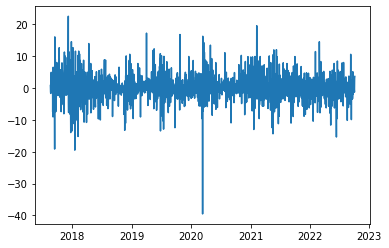

In [10]:
plt.plot((X_t1['Diferencia']*100)/X_t1['Anterior'])

In [11]:
def porintervalos (X):

    intervalos = (X['Diferencia-20']*100)/X['Anterior']
    for i in range(0,len(X)):
        int = intervalos[i]
        if (10 < int ):
            intervalos[i] = 1 
            
        elif (10>int>5):
            intervalos[i]=2               
        
        elif (5>int>0):
            intervalos[i]=3           
            
        elif (0>int>-5):
            intervalos[i]=4   
            
        elif (-5>int>-10):
            intervalos[i]=5               
        else:
            intervalos[i] = 6
    return intervalos

In [12]:
y_intervalos1 = porintervalos(X_t1)
y_intervalos1.value_counts()

6.0    578
1.0    470
4.0    261
3.0    247
2.0    163
5.0    154
dtype: int64

In [13]:
y_t1 = y_intervalos1.shift(-1).dropna()
X_t1 = X_t1[:-1]

In [14]:
p_train = 0.80 # Porcentaje de train.

trainX1 = X_t1[:int((len(X_t1))*p_train)] 
testX1 = X_t1[int((len(X_t1))*p_train):]

trainy1 = y_t1[:int((len(y_t1))*p_train)] 
testy1 = y_t1[int((len(y_t1))*p_train):]

**EXPERIMENTO 2: Añadimos VWAP, SMA10, SMA20, SMA55, EMA10, EMA20, EMA55, VMA10, VMA20, VMA55**

Vamos a añadir nuevas columnas y aplicar de nuevo el modelo.

Añadimos una columna para el VWAP: "precio medio ponderado por volumen". Este indicador nos muestra la relacion que hay entre el precio del BTC y el volumen de las operaciones diarias.

In [15]:
def vwap(df):
    q = df.Volume.values
    p = df.Close.values
    return df.assign(vwap=(p * q).cumsum() / q.cumsum())

X_t2 = X_t1.copy()
X_t2 = X_t2.groupby(X_t2.index.date, group_keys=False).apply(vwap)


**Medias moviles**. Las MM hacen la media segun el numero de pasos anteriores que se indiquen. Las mejores de corto plazo son las medias exponenciales 10,20 y 50.  En nuestro caso vamos a añadir:

- Media SMA con 10 horas anteriores
- Media SMA con 20 horas anteriores
- Media SMA con 55 horas anteriores
- Media EMA con 20 horas anteriores
- Media EMA con 55 horas anteriores
- Media VMA con 20 horas anteriores
- Media VMA con 55 horas anteriores

SMA: Una media móvil simple (o aritmética) es una media móvil aritmética calculada sumando los elementos de una serie temporal y dividiendo este total por el número de períodos de tiempo.

VMA: sirven para frenar el promedio cuando los precios están en el período de consolidación para evitar señales malas y acelerar el promedio cuando el mercado está en tendencia para aprovechar al máximo los precios en tendencia.

EMA: las medias móviles exponenciales dan más peso a los períodos más recientes. Esto los hace más seguras  que la SMA y por lo tanto pueden ser usadas para crear una mejor estrategia de trading con medias móviles.

Articulo explicando diferencias (para el desarrollo) : https://traderprofesional.com/bolsa/guias/analisis-tecnico/indicadores/medias-moviles/#:~:text=Media%20m%C3%B3vil%20variable%20(VMA),-La%20media%20m%C3%B3vil&text=La%20volatilidad%20es%20la%20medida,para%20los%20pr%C3%B3ximos%2030%20d%C3%ADas.

In [16]:
X_t2['SMA10'] = talib.MA(X_t2['Close'],timeperiod=10,matype=0) #SMA
X_t2['SMA20'] = talib.MA(X_t2['Close'],timeperiod=20,matype=0) #SMA
X_t2['SMA55'] = talib.MA(X_t2['Close'],timeperiod=55,matype=0) #SMA
X_t2['EMA10'] = talib.MA(X_t2['Close'],timeperiod=10,matype=1) #EMA
X_t2['EMA20'] = talib.MA(X_t2['Close'],timeperiod=20,matype=1) #EMA
X_t2['EMA55'] = talib.MA(X_t2['Close'],timeperiod=55,matype=1) #EMA
X_t2['VMA10'] = talib.MA(X_t2['Close'],timeperiod=10,matype=2) #EMA
X_t2['VMA20'] = talib.MA(X_t2['Close'],timeperiod=20,matype=2) #VMA
X_t2['VMA55'] = talib.MA(X_t2['Close'],timeperiod=55,matype=2) #VMA
X_t2 = X_t2.dropna()


In [17]:
y_intervalos2 = porintervalos(X_t2)
y_intervalos2.value_counts()

6.0    550
1.0    456
4.0    255
3.0    244
2.0    162
5.0    151
dtype: int64

In [18]:
y_t2 = y_intervalos2.shift(-1).dropna()
X_t2 = X_t2[:-1]

In [19]:
p_train = 0.80 # Porcentaje de train.

trainX2 = X_t2[:int((len(X_t2))*p_train)] 
testX2 = X_t2[int((len(X_t2))*p_train):]

trainy2 = y_t2[:int((len(y_t2))*p_train)] 
testy2 = y_t2[int((len(y_t2))*p_train):]

**EXPERIMENTO 3: Añadimos el indicador MACD, el indicador KDJ, Bandas de Bollinger,RSI, Estocastico,Indicador ATR**

**Indicador MACD (Moving Average Convergene Divergence)** :  mide la convergencia y divergencia en el tiempo de dos medias móviles del precio de un activo. En otras palabras el MACD señala, en cada momento, la separación entre el valor de dos medias móviles con diferente período de cálculo.
Para el cálculo del MACD se emplea una media móvil exponencial con un período corto de cálculo y otra media móvil exponencial con un período de tiempo medio. Normalmente, para la media corta se emplean 12 períodos y, para la otra media, 26 períodos. (MACD = EMA (12) – EMA (26))

Después de obtener el MACD, se calcula, a su vez, su media móvil exponencial. Para realizar este cálculo se suele emplear una media de 9 períodos. Esta media móvil se denomina Señal.

Fuente: https://www.avatrade.es/educacion/professional-trading-strategies/macd-trading-strategies

In [20]:
X_t3 = X_t2.copy()
dif, dea, bar = talib.MACD(X_t3['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
# calculamos EMA1= media movil de precio de cierre el dia 12, EMA2 = media movil del precio de cierre dia 26, DEA = 9
dif[np.isnan(dif)],dea[np.isnan(dea)],bar[np.isnan(bar)]=0,0,0 #para eliminar valores nulos
X_t3['MACD-dif'] = dif
X_t3['MACD-dea'] = dea
X_t3['MACD-bar'] = bar

**Indicador KDJ**: las líneas K y D del oscilador estocástico (señalar una inversión de tendencia inminente cuando ocurren divergencias alcistas y bajistas.) y la J muestra la divergencia del valor D de la K.

In [21]:
X_t3['K'], X_t3['D'] = talib.STOCH(X_t3['High'].values, X_t3['Low'].values, X_t3['Close'].values, 
                                    fastk_period=9, slowk_period=3,slowk_matype=0, slowd_period=3, slowd_matype=0)
X_t3['K'].fillna(0,inplace=True)
X_t3['D'].fillna(0,inplace=True)
X_t3['J']=3*X_t3['K']-2*X_t3['D']

**Bandas de Bollinger**: El indiador bandas de Bollinger utiliza una medida estadística conocida como la desviación estándar para determinar dónde podría tener lugar un posible nivel de soporte o resistencia.

Fuente: https://admiralmarkets.com/es/education/articles/forex-strategy/bandas-de-bollinger?utm_source=google&utm_medium=cpc&utm_campaign=ES_ES_performance_max_new&utm_term=&gclid=EAIaIQobChMI3PbX97-y9wIVR4xoCR3BlwjTEAAYAiAAEgK2dvD_BwE

In [22]:
X_t3['Banda_superior'], X_t3['Banda_media'], X_t3['Banda_inferior'] = talib.BBANDS(X_t3['Close'], timeperiod=20)

**RSI(Relative Strength Index)**: es un indicador de tipo oscilador que refleja la fuerza relativa de los movimientos alcistas, en comparación con los movimientos bajistas. Es utilizado por los traders para medir la fuerza de una tendencia e identificar señales de fin de tendencia.

In [23]:
X_t3['RSI'] = talib.RSI(X_t3['Close'],14)

**Estocastico** :  significa la comparación realizada por el indicador estocástico MT4 entre el precio de cierre actual y sus precios de cierre anteriores durante un período elegido. El Oscilador Estocástico se mide usando las líneas K y D.

K = 100 [(C – Ln) / (Hn – Ln)] -> C es el precio de cierre actual;
Ln es el precio más bajo durante las últimas "n" sesiones de trading;
Hn es el precio más alto durante las últimas "n" sesiones de trading.

D = es la media móvil de %K durante N períodos

➡ Si el precio de cierre actual es cercano al precio más alto (Hn) del período en cuestión, el estocástico estará cerca del 100 %

➡ Si el precio de cierre actual está cerca del precio más bajo (Bn) del período relevante, el estocástico estará cerca del 0 %

Fuente: https://admiralmarkets.com/es/education/articles/forex-indicators/indicador-estocastico?utm_source=google&utm_medium=cpc&utm_campaign=ES_ES_performance_max_new&utm_term=&gclid=EAIaIQobChMIm-bP_sKy9wIV1vZRCh0T1gvKEAAYAiAAEgIzZfD_BwE

In [24]:
X_t3['slowk'], X_t3['slowd'] = talib.STOCH(X_t3['High'], X_t3['Low'], X_t3['Close'], 
                                       fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period= 3,slowd_matype=0)

**Indicador ATR (Average True Range):** Lo que nos viene a calcular este indicador, es la volatilidad existente en el periodo actual, para que podamos actuar en consecuencia. Si vemos que la volatilidad aumenta o disminuye, podremos tomar decisiones de compra o de venta.

La fórmula es muy sencilla, y es que para el cálculo toma el valor más alto de estos tres:

El máximo de la última vela, menos el mínimo de la última vela. El máximo de la última vela, menos el cierre de la vela anterior (valor absoluto). El mínimo de la última vela, menos el cierre de la vela anterior (valor absoluto).

Fuente: https://www.novatostradingclub.com/indicadores/atr-indicador/

In [25]:
X_t3['ATR'] = talib.ATR(X_t3['High'], X_t3['Low'], X_t3['Close'], timeperiod = 14)

**Funciones de Reconocimiento de patrones (BELTHOLD)**: al ingresar los datos de apertura, máximo, mínimo y cierre de la acción en estudio la función seleccionada retornara uno de tres posibles valores enteros, 0 cuando no reconoce patrón, 100 cuando reconoce un patrón alcista y -100 cuando reconoce un patrón bajista.

Fuente: https://www.investopedia.com/terms/b/bearishbelthold.asp

In [26]:
X_t3 = X_t3.copy()
X_t3['BELTHOLD'] = talib.CDLBELTHOLD(X_t3['Open'],X_t3['High'],X_t3['Low'],X_t3['Close'])
X_t3 = X_t3.dropna()

Preparamos los datos:

In [27]:
y_intervalos3 = porintervalos(X_t3)
y_intervalos3.value_counts()

6.0    534
1.0    456
4.0    253
3.0    243
2.0    162
5.0    150
dtype: int64

In [28]:
y_t3 = y_intervalos3.shift(-1).dropna()
X_t3 = X_t3[:-1]

In [29]:
p_train = 0.80 # Porcentaje de train.

trainX3 = X_t3[:int((len(X_t3))*p_train)] 
testX3 = X_t3[int((len(X_t3))*p_train):]

trainy3 = y_t3[:int((len(y_t3))*p_train)] 
testy3 = y_t3[int((len(y_t3))*p_train):]